<a href="https://colab.research.google.com/github/Adithan01/Projects/blob/main/segmentation_isic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import necessary libraries
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
import cv2
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt

In [ ]:
!pip install -q tensorflow opencv-python-headless tqdm

In [ ]:
from tqdm import tqdm  # For progress bars

In [ ]:
# Check if GPU is available and set up
device_name = tf.test.gpu_device_name()
if 'GPU' not in device_name:
    raise SystemError('GPU device not found')
print('Found GPU at:', device_name)

Found GPU at: /device:GPU:0


In [ ]:

# Ensure Colab environment
if not os.path.exists("ISIC2018_Task1-2_Training_Input.zip"):
    # Training data
    !wget "https://isic-challenge-data.s3.amazonaws.com/2018/ISIC2018_Task1-2_Training_Input.zip"
    !unzip -q "ISIC2018_Task1-2_Training_Input.zip"
    !rm "ISIC2018_Task1-2_Training_Input.zip"

# Training ground truth
if not os.path.exists("ISIC2018_Task1_Training_GroundTruth.zip"):
    !wget "https://isic-challenge-data.s3.amazonaws.com/2018/ISIC2018_Task1_Training_GroundTruth.zip"
    !unzip -q "ISIC2018_Task1_Training_GroundTruth.zip"
    !rm "ISIC2018_Task1_Training_GroundTruth.zip"

--2024-11-05 13:05:37--  https://isic-challenge-data.s3.amazonaws.com/2018/ISIC2018_Task1-2_Training_Input.zip
Resolving isic-challenge-data.s3.amazonaws.com (isic-challenge-data.s3.amazonaws.com)... 54.231.233.225, 16.182.101.65, 16.15.192.104, ...
Connecting to isic-challenge-data.s3.amazonaws.com (isic-challenge-data.s3.amazonaws.com)|54.231.233.225|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11165358566 (10G) [application/zip]
Saving to: ‘ISIC2018_Task1-2_Training_Input.zip’

ISIC2018_Task1-2_Tr 100%[===================>]  10.40G  42.2MB/s    in 3m 55s  

2024-11-05 13:09:33 (45.3 MB/s) - ‘ISIC2018_Task1-2_Training_Input.zip’ saved [11165358566/11165358566]

--2024-11-05 13:12:01--  https://isic-challenge-data.s3.amazonaws.com/2018/ISIC2018_Task1_Training_GroundTruth.zip
Resolving isic-challenge-data.s3.amazonaws.com (isic-challenge-data.s3.amazonaws.com)... 54.231.224.153, 3.5.29.166, 52.217.235.185, ...
Connecting to isic-challenge-data.s3.amazonaws.

In [ ]:
def preprocess_data(img_size=(256, 256)):
    train_images = []
    train_masks = []

    # Load and preprocess training images with progress bar
    print("Processing training images and masks...")
    for img_file in tqdm(os.listdir('ISIC2018_Task1-2_Training_Input'), desc="Images"):
        if img_file.endswith('.jpg'):
            img_path = os.path.join('ISIC2018_Task1-2_Training_Input', img_file)
            img = cv2.imread(img_path)
            img = cv2.resize(img, img_size)
            img = img / 255.0  # Normalize
            train_images.append(img)

            # Load and resize corresponding mask
            mask_file = img_file.replace('.jpg', '_segmentation.png')
            mask_path = os.path.join('ISIC2018_Task1_Training_GroundTruth', mask_file)
            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
            mask = cv2.resize(mask, img_size)
            mask = mask / 255.0  # Normalize
            train_masks.append(mask)

    return np.array(train_images), np.array(train_masks)[..., np.newaxis]

In [ ]:
# U-Net model architecture
def build_unet(input_shape=(256, 256, 3)):
    inputs = layers.Input(input_shape)

    # Encoder
    conv1 = layers.Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = layers.Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = layers.Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = layers.Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = layers.Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = layers.Conv2D(256, 3, activation='relu', padding='same')(conv3)
    pool3 = layers.MaxPooling2D(pool_size=(2, 2))(conv3)

    # Bridge
    conv4 = layers.Conv2D(512, 3, activation='relu', padding='same')(pool3)
    conv4 = layers.Conv2D(512, 3, activation='relu', padding='same')(conv4)

    # Decoder
    up5 = layers.Conv2DTranspose(256, 2, strides=(2, 2), padding='same')(conv4)
    up5 = layers.concatenate([up5, conv3])
    conv5 = layers.Conv2D(256, 3, activation='relu', padding='same')(up5)
    conv5 = layers.Conv2D(256, 3, activation='relu', padding='same')(conv5)

    up6 = layers.Conv2DTranspose(128, 2, strides=(2, 2), padding='same')(conv5)
    up6 = layers.concatenate([up6, conv2])
    conv6 = layers.Conv2D(128, 3, activation='relu', padding='same')(up6)
    conv6 = layers.Conv2D(128, 3, activation='relu', padding='same')(conv6)

    up7 = layers.Conv2DTranspose(64, 2, strides=(2, 2), padding='same')(conv6)
    up7 = layers.concatenate([up7, conv1])
    conv7 = layers.Conv2D(64, 3, activation='relu', padding='same')(up7)
    conv7 = layers.Conv2D(64, 3, activation='relu', padding='same')(conv7)

    outputs = layers.Conv2D(1, 1, activation='sigmoid')(conv7)

    model = models.Model(inputs=inputs, outputs=outputs)
    return model


In [ ]:
# Training function with progress bar for each epoch
def train_model(model, X_train, y_train, X_val, y_val):
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy', tf.keras.metrics.MeanIoU(num_classes=2)])

    callbacks = [
        ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_loss'),
        EarlyStopping(patience=5, monitor='val_loss')
    ]

    history = model.fit(X_train, y_train,
                        batch_size=16,
                        epochs=50,
                        validation_data=(X_val, y_val),
                        callbacks=callbacks,
                        verbose=1)
    return history

In [ ]:
from tensorflow.keras.utils import Sequence

In [ ]:
# Custom data generator to avoid loading everything into memory
class DataGenerator(Sequence):
    def __init__(self, img_filenames, mask_filenames, batch_size=16, img_size=(256, 256), shuffle=True):
        self.img_filenames = img_filenames
        self.mask_filenames = mask_filenames
        self.batch_size = batch_size
        self.img_size = img_size
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.img_filenames) / self.batch_size))

    def on_epoch_end(self):
        if self.shuffle:
            temp = list(zip(self.img_filenames, self.mask_filenames))
            np.random.shuffle(temp)
            self.img_filenames, self.mask_filenames = zip(*temp)

    def __getitem__(self, index):
        # Generate batch indices
        batch_img_filenames = self.img_filenames[index * self.batch_size:(index + 1) * self.batch_size]
        batch_mask_filenames = self.mask_filenames[index * self.batch_size:(index + 1) * self.batch_size]

        # Generate data for this batch
        X, y = self.__data_generation(batch_img_filenames, batch_mask_filenames)

        return X, y

    def __data_generation(self, batch_img_filenames, batch_mask_filenames):
      X = np.empty((self.batch_size, *self.img_size, 3), dtype=np.float16)
      y = np.empty((self.batch_size, *self.img_size, 1), dtype=np.float16)

      for i, (img_file, mask_file) in enumerate(zip(batch_img_filenames, batch_mask_filenames)):
          # Load and preprocess image
          img = cv2.imread(img_file)
          if img is None:
              print(f"Warning: Image file {img_file} could not be loaded. Skipping.")
              continue
          img = cv2.resize(img, self.img_size)
          img = img / 255.0  # Normalize
          X[i,] = img.astype(np.float16)

          # Load and preprocess mask
          mask = cv2.imread(mask_file, cv2.IMREAD_GRAYSCALE)
          if mask is None:
              print(f"Warning: Mask file {mask_file} could not be loaded. Skipping.")
              continue
          mask = cv2.resize(mask, self.img_size)
          mask = mask / 255.0  # Normalize
          y[i,] = np.expand_dims(mask, axis=-1).astype(np.float16)

      return X, y


# Load file paths
def load_filenames():
    img_filenames = sorted([os.path.join('ISIC2018_Task1-2_Training_Input', f)
                            for f in os.listdir('ISIC2018_Task1-2_Training_Input') if f.endswith('.jpg')])
    mask_filenames = sorted([os.path.join('ISIC2018_Task1_Training_GroundTruth', f.replace('.jpg', '_segmentation.png'))
                             for f in img_filenames])
    return img_filenames, mask_filenames

# Download data

In [ ]:
def load_filenames():
    # Get sorted list of image filenames
    img_filenames = sorted([os.path.join('ISIC2018_Task1-2_Training_Input', f)
                            for f in os.listdir('ISIC2018_Task1-2_Training_Input') if f.endswith('.jpg')])

    # Get corresponding mask filenames by correctly joining with the ground truth folder
    mask_filenames = sorted([os.path.join('ISIC2018_Task1_Training_GroundTruth', f.replace('.jpg', '_segmentation.png'))
                             for f in os.listdir('ISIC2018_Task1-2_Training_Input') if f.endswith('.jpg')])

    return img_filenames, mask_filenames


In [ ]:
img_filenames, mask_filenames = load_filenames()
train_img_filenames, val_img_filenames, train_mask_filenames, val_mask_filenames = train_test_split(
    img_filenames, mask_filenames, test_size=0.2, random_state=42)

# Initialize data generators
train_generator = DataGenerator(train_img_filenames, train_mask_filenames, batch_size=16, img_size=(256, 256))
val_generator = DataGenerator(val_img_filenames, val_mask_filenames, batch_size=16, img_size=(256, 256))

# Model training with generator

In [ ]:
print("Building and training model...")
with tf.device('/GPU:0'):
    model = build_unet()

Building and training model...


In [ ]:
# Compile the model after building it
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', tf.keras.metrics.MeanIoU(num_classes=2)])

In [ ]:
history = model.fit(train_generator,
                        validation_data=val_generator,
                        epochs=3,
                        callbacks=[
                            # Update ModelCheckpoint to use the `.keras` extension
ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_loss'),
                            EarlyStopping(patience=5, monitor='val_loss')],verbose=1)

Epoch 1/3
129/129 ━━━━━━━━━━━━━━━━━━━━ 456s 3s/step - accuracy: 0.8399 - loss: 0.4172 - mean_io_u_2: 0.3018 - val_accuracy: 0.7891 - val_loss: 0.4522 - val_mean_io_u_2: 0.3452
Epoch 2/3
129/129 ━━━━━━━━━━━━━━━━━━━━ 480s 3s/step - accuracy: 0.8446 - loss: 0.3772 - mean_io_u_2: 0.3003 - val_accuracy: 0.8628 - val_loss: 0.3415 - val_mean_io_u_2: 0.3452
Epoch 3/3
129/129 ━━━━━━━━━━━━━━━━━━━━ 438s 3s/step - accuracy: 0.8682 - loss: 0.3349 - mean_io_u_2: 0.2962 - val_accuracy: 0.8669 - val_loss: 0.3241 - val_mean_io_u_2: 0.3460


In [ ]:
# Step 5: Evaluate model
test_loss, test_accuracy, test_iou = model.evaluate(val_generator)
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test IoU: {test_iou:.4f}")

32/32 ━━━━━━━━━━━━━━━━━━━━ 87s 3s/step - accuracy: 0.8639 - loss: 0.3302 - mean_io_u_2: 0.3720
Test Accuracy: 0.8668
Test IoU: 0.3457


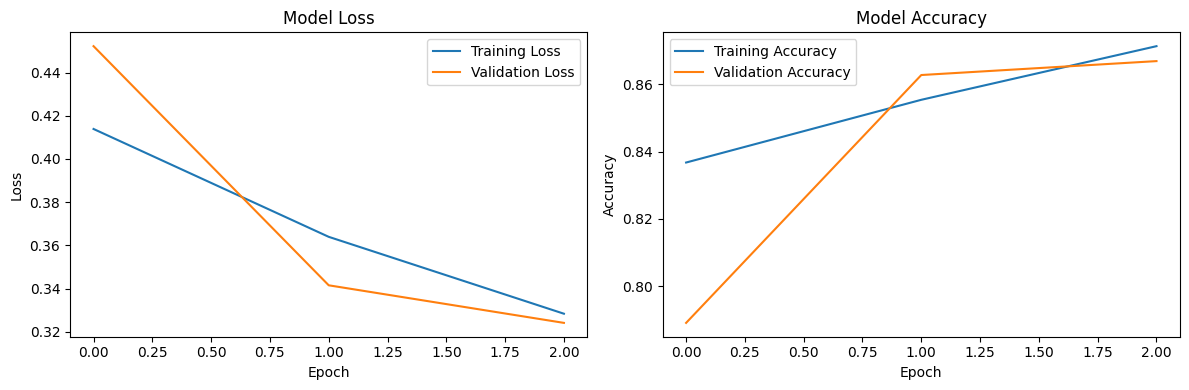

In [ ]:
# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Save the model in the SavedModel format (ideal for portability)
model.save('segmentation_model.keras')  # This creates a 'segmentation_model' directory


In [ ]:
from google.colab import files
files.download( 'segmentation_model.keras')  # For .keras format


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import os
from tensorflow import keras
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
model = keras.models.load_model('segmentation_model.keras')


In [ ]:
def load_filenames():
    img_filenames = sorted([os.path.join('ISIC2018_Task1-2_Training_Input', f)
                            for f in os.listdir('ISIC2018_Task1-2_Training_Input') if f.endswith('.jpg')])
    mask_filenames = sorted([os.path.join('ISIC2018_Task1_Training_GroundTruth', f.replace('.jpg', '_segmentation.png'))
                             for f in img_filenames])
    return img_filenames, mask_filenames

# Get the image and mask filenames
img_filenames, mask_filenames = load_filenames()

# Check if there are any images and get the first one
if img_filenames:
    first_image_path = img_filenames[0]
    print(f"The first image is located at: {first_image_path}")
else:
    print("No images found.")

The first image is located at: ISIC2018_Task1-2_Training_Input/ISIC_0000000.jpg


In [ ]:
image_path = "ISIC2018_Task1-2_Training_Input/ISIC_0000000.jpg"  # Replace with the name of the image you want to check

# Check if the image file exists
if os.path.exists(image_path):
    print(f"The image '{image_path}' exists.")
else:
    print(f"The image '{image_path}' does not exist.")

The image 'ISIC2018_Task1-2_Training_Input/ISIC_0000000.jpg' exists.


In [ ]:
def segment_image(model, image_path, img_size=(256, 256)):
    # Load and preprocess image
    img = cv2.imread(image_path)
    img_resized = cv2.resize(img, img_size)
    img_normalized = img_resized / 255.0
    img_input = np.expand_dims(img_normalized, axis=0)  # Add batch dimension

    # Predict mask
    mask_pred = model.predict(img_input)[0]  # Remove batch dimension
    mask_resized = cv2.resize(mask_pred, (img.shape[1], img.shape[0]))

    # Threshold mask to create binary mask
    mask_binary = (mask_resized > 0.5).astype(np.uint8)

    # Apply mask to original image to extract segmented part
    segmented_img = img * mask_binary[..., np.newaxis]

    # Plot original, mask, and segmented image
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.title("Original Image")
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.title("Predicted Mask")
    plt.imshow(mask_binary, cmap='gray')
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.title("Segmented Image")
    plt.imshow(cv2.cvtColor(segmented_img, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.show()

    return segmented_img

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


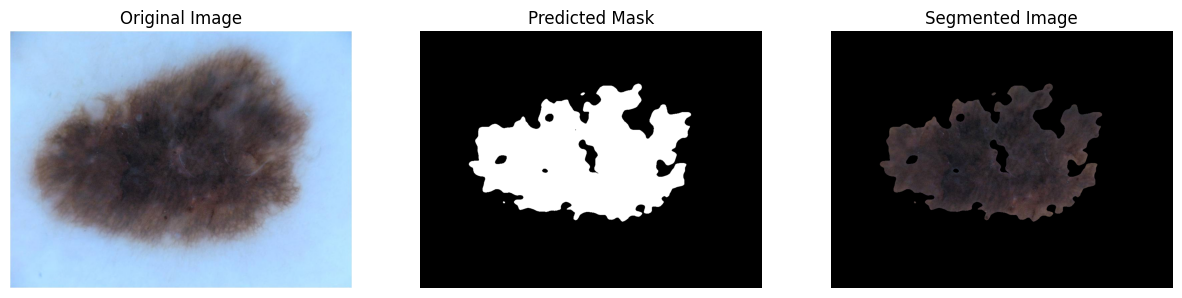

In [ ]:
segmented_output = segment_image(model, image_path)